In [1]:
import pandas as pd
import numpy as np
import librosa
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf

from scene_cls_model import Cnn_9layers_AvgPooling

2024-05-21 12:38:03.025610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 12:38:07.733028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

In [3]:
eval_df = pd.read_csv('predictions.csv')

In [4]:
eval_df.head()

,Filename,Predicted Label,Actual Label
0,/work/aistwal/dataset_tau2019/extracted-files/...,street_pedestrian,street_pedestrian
1,/work/aistwal/dataset_tau2019/extracted-files/...,metro,metro
2,/work/aistwal/dataset_tau2019/extracted-files/...,street_traffic,park
3,/work/aistwal/dataset_tau2019/extracted-files/...,street_pedestrian,street_pedestrian
4,/work/aistwal/dataset_tau2019/extracted-files/...,street_traffic,street_traffic


In [5]:
# Correct Predictions

In [6]:
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
correct_pred.shape

(2230, 3)

In [7]:
correct_pred.head()

,Filename,Predicted Label,Actual Label
0,/work/aistwal/dataset_tau2019/extracted-files/...,street_pedestrian,street_pedestrian
1,/work/aistwal/dataset_tau2019/extracted-files/...,metro,metro
3,/work/aistwal/dataset_tau2019/extracted-files/...,street_pedestrian,street_pedestrian
4,/work/aistwal/dataset_tau2019/extracted-files/...,street_traffic,street_traffic
7,/work/aistwal/dataset_tau2019/extracted-files/...,airport,airport


In [8]:
# Incorrect Predictions
incorrect_pred = eval_df[eval_df['Predicted Label'] != eval_df['Actual Label']]
incorrect_pred.shape

(1955, 3)

In [9]:
# Checking for accuracy to be 53.29%
correct_pred.shape[0]/(correct_pred.shape[0]+incorrect_pred.shape[0]) * 100

53.28554360812425

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
# Instantiate and load the model
model = Cnn_9layers_AvgPooling(classes_num=10, activation="logsoftmax")
model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_10_16.pth'
# model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_new_10_16.pth'
model_name = model_path.split('/')[-1]
print("model name: ", model_name)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

model name:  tau_2019_conv_10_16.pth


Cnn_9layers_AvgPooling(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [49]:
correct_audio_list = correct_pred['Filename'].sample(n=10, random_state=1).tolist()
correct_audio_list

['/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44468-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8431-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44556-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7522-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6192-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8560-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-

In [50]:
labels = [
    "airport", "shopping_mall", "metro_station", "street_pedestrian",
    "public_square", "street_traffic", "tram", "bus", "metro", "park"]
lb_to_idx = {lb: idx for idx, lb in enumerate(labels)}
idx_to_lb = {idx: lb for idx, lb in enumerate(labels)}

In [51]:
def get_grayscale_cam(model, target_layers, tensor_x, targets):
    
    print("Target_layer ", target_layers)
    cam = GradCAM(model=model,target_layers=target_layers)
    grayscale_cam = cam(input_tensor=tensor_x, 
                        targets=targets)
    # print("original grayscale_cam", grayscale_cam.shape)
    
    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]
    return grayscale_cam

In [52]:
# target_layers = [model.conv_block4.conv2]
target_layers = [model.conv_block4.bn2]

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
targets = None


## The index of the class to visualize
# class_index = 3  # For example, class index 3 for class "STREET PEDESTRIAN"

## Using the ClassifierOutputTarget to focus on a specific class
# targets = [ClassifierOutputTarget(class_index)]

In [53]:
def predict(model, inputs):
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    return predicted

In [54]:
def display_log_mel_spectrogram(audioname, version, input_feature, model_name):
    print(audioname, "Log-Mel Feature Shape : ", input_feature.shape)
    plt.figure(figsize=(15, 6))
    plt.title(f'SPECTROGRAM FOR {audioname}')
    root_dir = '/work/aistwal/MMDS_MasterThesis/models/asc'
    save_path = os.path.join(root_dir, 'files', model_name, version)
    
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    file_path = os.path.join(save_path, f'{audioname}-spectrogram.png')
    librosa.display.specshow(input_feature, x_axis='time', y_axis='linear', sr=32000)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [55]:
def blackout_unimportant_features(grayscale_cam, input_spectrogram, threshold=0.5):
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    # Create a mask for important regions
    important_mask = normalized_cam >= threshold
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(input_spectrogram)
    
    # Create a copy of the input spectrogram to modify
    modified_spectrogram = np.copy(input_spectrogram)
    
    # Blackout unimportant regions by setting them to the minimum value
    modified_spectrogram[~important_mask] = min_value
    
    return modified_spectrogram

In [56]:
audio_path = correct_audio_list[-2]
print(audio_path)
# Load the audio file
audio, sr = librosa.load(audio_path, sr = 32000)
audio.shape, sr
print("Sampling rate: ",sr)
Audio(data=audio, rate=sr)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45063-a.wav
Sampling rate:  32000


/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44609-a.wav
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Shape of grayscale_cam  (64, 641)
Shape of log_mel_spectrogram  (64, 641)
Shape of modified_spectrogram  (64, 641)
Prediction for  street_pedestrian-lisbon-1174-44609-a.wav is  street_pedestrian
street_pedestrian-lisbon-1174-44609-a.wav Log-Mel Feature Shape :  (64, 641)


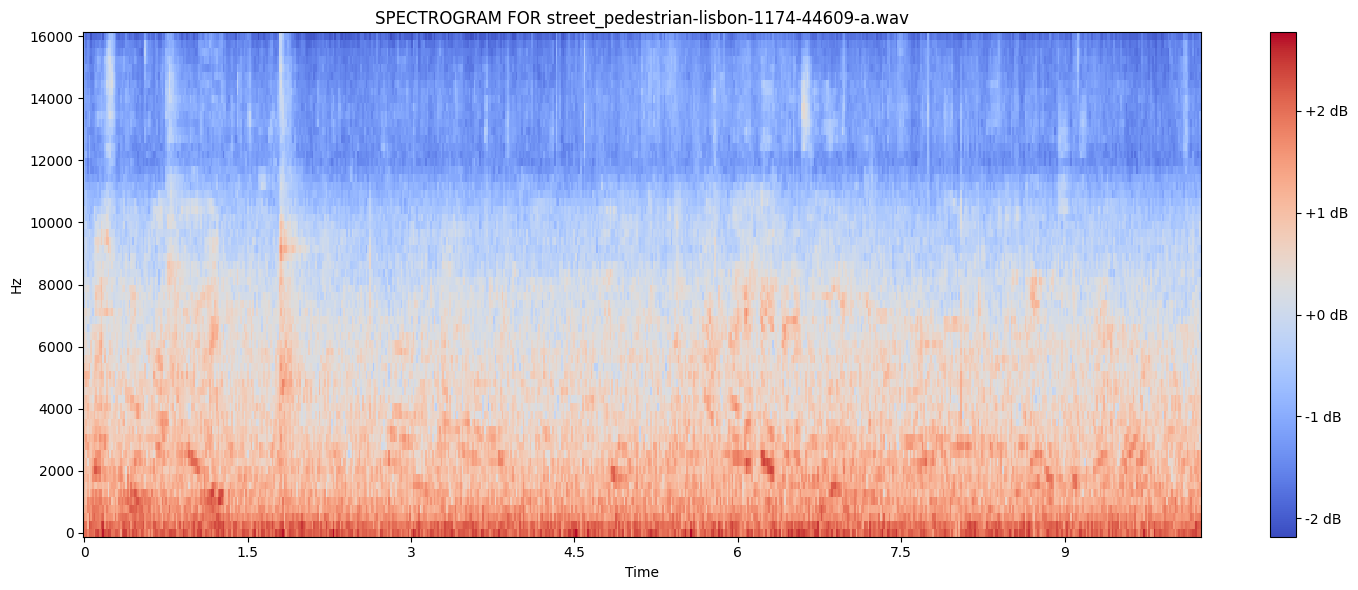

street_pedestrian-lisbon-1174-44609-a.wav_modified Log-Mel Feature Shape :  (64, 641)


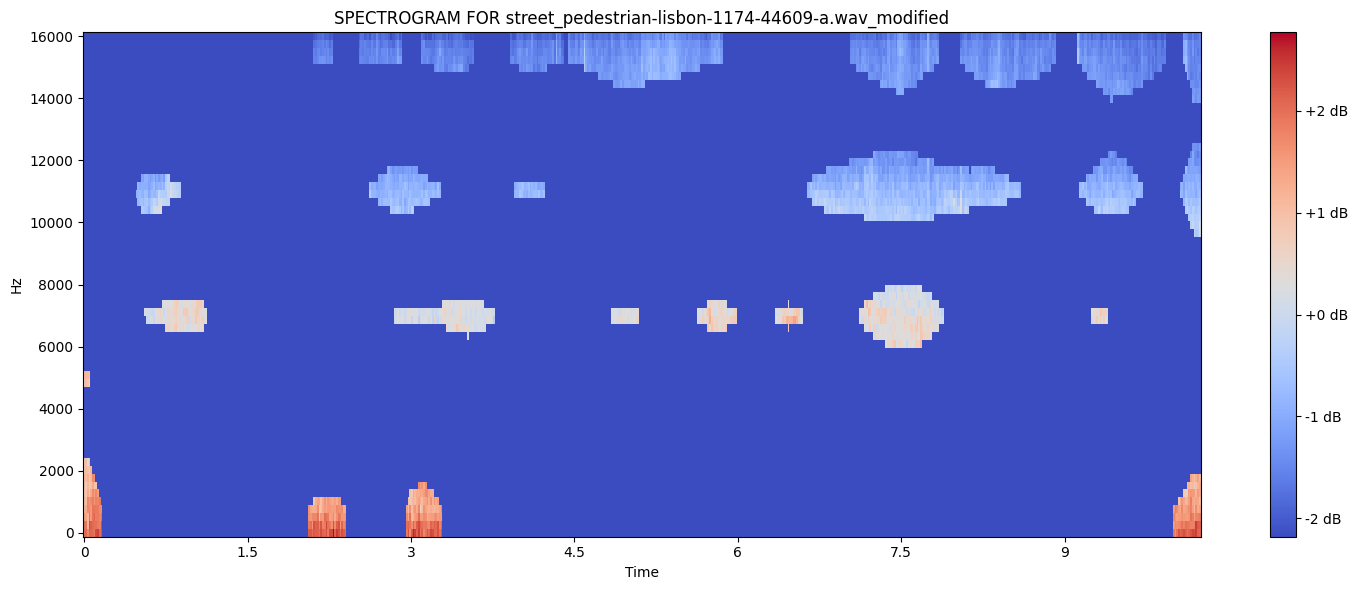

In [67]:
for audio in correct_audio_list[9:]:
    print(audio)
    audioname = audio.split('/')[-1]
    # Load the audio file
    y, sr = librosa.load(audio, sr=32000)
    
    # Convert to log mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=500, n_mels=64)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Normalize the spectrogram
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
    #print(log_mel_spectrogram.shape) #(64, 641)
    
    # Convert to torch tensor
    log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
    # print(log_mel_spectrogram_tensor.shape) torch.Size([1, 64, 641])
    
    grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)

    print("Shape of grayscale_cam ", grayscale_cam.shape)
    print("Shape of log_mel_spectrogram ", log_mel_spectrogram.shape)
    
    modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)
    # Convert modified_spectrogram to torch tensor
    modified_spectrogram_tensor = torch.tensor(modified_spectrogram, dtype=torch.float32).unsqueeze(0)

    print("Shape of modified_spectrogram ",modified_spectrogram.shape)
    preds = predict(model, log_mel_spectrogram_tensor)
    
    # Print the predicted label
    preds = preds.cpu().numpy()
    pred_label = idx_to_lb[preds[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
    display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
    break
    

In [70]:
#testing the model on an unseen test audio 
test_dir = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-evaluation/audio/'
afile = '2420.wav'
audio = test_dir + afile
audio 

'/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-evaluation/audio/2420.wav'

In [72]:
# Display Audio
audio, sr = librosa.load(audio, sr = 32000)
audio.shape, sr
print("Sampling rate: ",sr)
Audio(data=audio, rate=sr)

Sampling rate:  32000


/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-evaluation/audio/2420.wav
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Shape of grayscale_cam  (64, 641)
Shape of log_mel_spectrogram  (64, 641)
Shape of modified_spectrogram  (64, 641)
Prediction for  2420.wav is  street_pedestrian
2420.wav Log-Mel Feature Shape :  (64, 641)


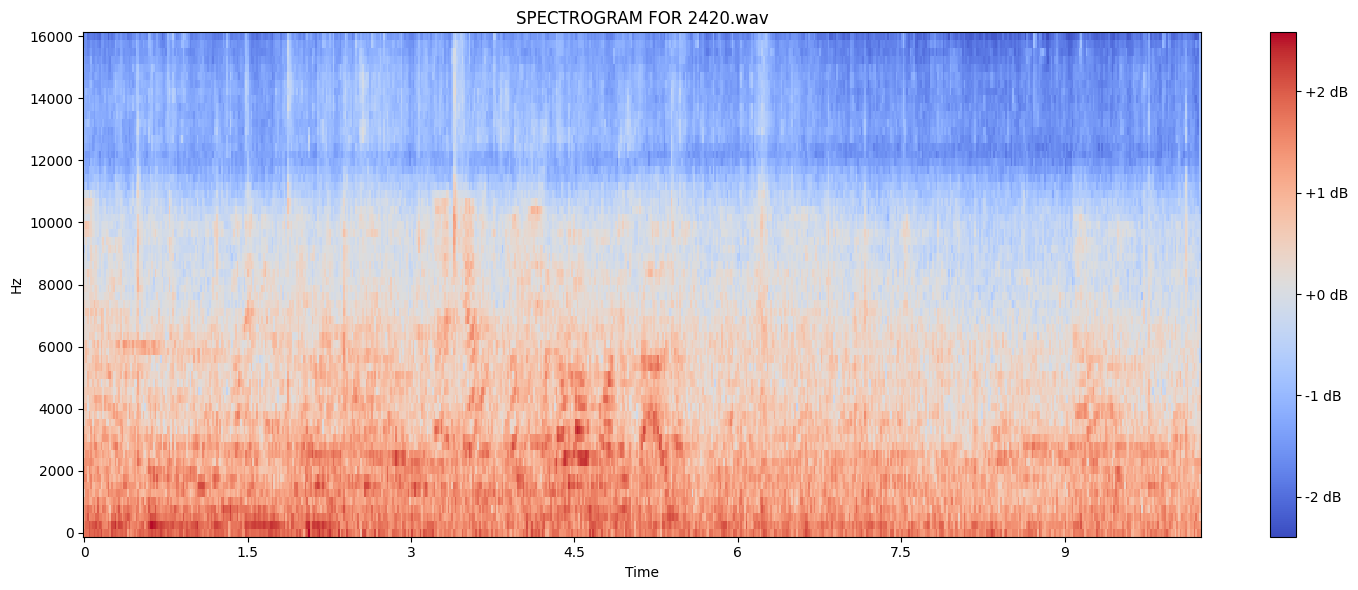

2420.wav_modified Log-Mel Feature Shape :  (64, 641)


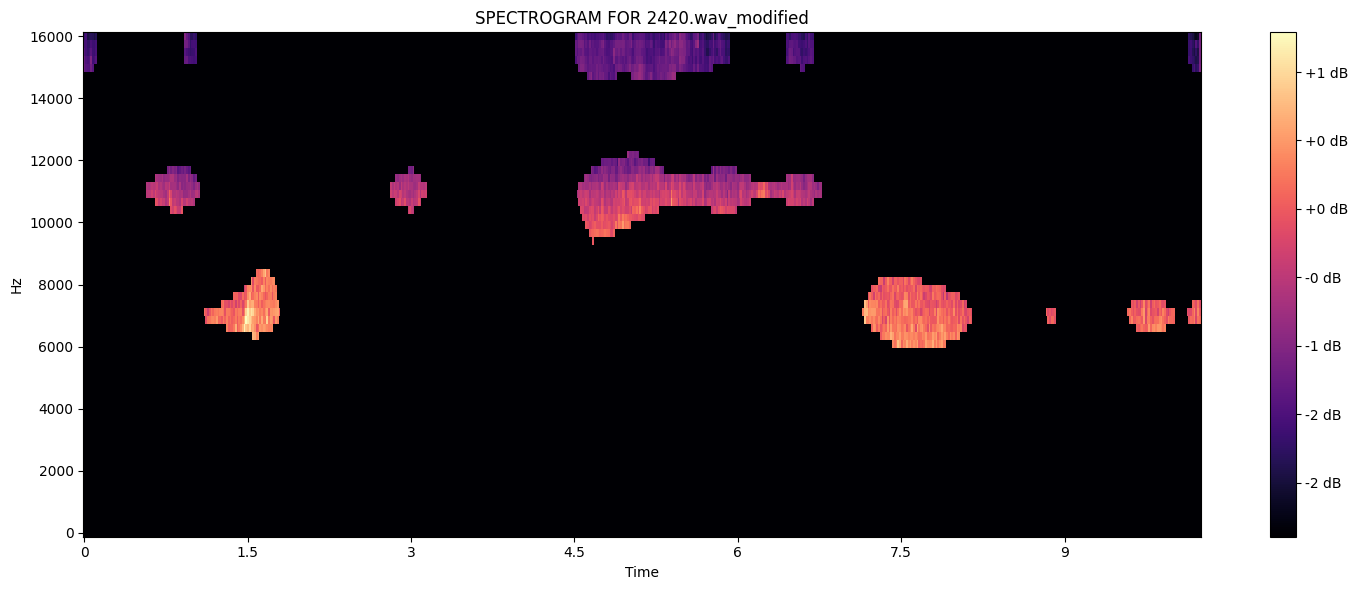

In [71]:
print(audio)
audioname = audio.split('/')[-1]
# Load the audio file
y, sr = librosa.load(audio, sr=32000)

# Convert to log mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=500, n_mels=64)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Normalize the spectrogram
log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
#print(log_mel_spectrogram.shape) #(64, 641)

# Convert to torch tensor
log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
# print(log_mel_spectrogram_tensor.shape) torch.Size([1, 64, 641])

grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)

print("Shape of grayscale_cam ", grayscale_cam.shape)
print("Shape of log_mel_spectrogram ", log_mel_spectrogram.shape)

modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)
# Convert modified_spectrogram to torch tensor
modified_spectrogram_tensor = torch.tensor(modified_spectrogram, dtype=torch.float32).unsqueeze(0)

print("Shape of modified_spectrogram ",modified_spectrogram.shape)
preds = predict(model, log_mel_spectrogram_tensor)

# Print the predicted label
preds = preds.cpu().numpy()
pred_label = idx_to_lb[preds[0]]
print("Prediction for ",audioname ,"is ", pred_label)
display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)